In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

Summary:
    
    For this task, by manipulating the two data sets, the significance of the treatment effect was investigated, which turned out to be non-significant for a general user group. However, it does make some difference for different users with different first_inquiry_message length.
    The findings, suggestions and discussion can be found at the bottom, in Conclusion section

In [2]:
%matplotlib inline

In [3]:
#helper functions
def timeSeq(s_year,s_month,s_day, e_year, e_month, e_day):
    """return list of dates"""
    
    dt = datetime(s_year,s_month,s_day)
    end = datetime(e_year,e_month,e_day)
    
    step = timedelta(days = 1)

    dates = []
    
    while dt < end:
        dates.append(dt.strftime('%Y-%m-%d'))
        dt += step
    return dates

def check_nan(data):
    for c in data.columns:
        if np.sum(pd.isnull(data[c])) > 0:
            print c,'has', np.sum(pd.isnull(data[c])),'missing values'

# Read and check the data set

In [4]:
assignments = pd.read_csv('assignments.csv')
contacts = pd.read_csv('contacts.csv')  

In [5]:
assignments.head(2)

,id_user,ab
0,f966752c-8533-48b2-af6f-8c6797d2b247,treatment
1,873f93fb-234c-4cfb-83c7-27ff0e582a8e,treatment


In [6]:
contacts.head(2)

,id_guest,id_host,id_listing,ts_interaction_first,ts_accepted_at_first,m_first_message_length
0,f966752c-8533-48b2-af6f-8c6797d2b247,4405ab66-1c68-449b-abd9-1ad1892a6c4d,fe07e0c4-c317-44bc-a82d-5b599a248049,1/1/13 23:04,NaN,230.0
1,873f93fb-234c-4cfb-83c7-27ff0e582a8e,aa41b57b-e29f-4c95-bf27-48f27519e419,d47717da-315a-42c2-8888-9b7d4bea8829,1/2/13 0:21,NaN,98.0


In [7]:
assignments.describe(include = 'all')

,id_user,ab
count,10000,10000
unique,9094,2
top,ae290fb1-f0ce-4589-908c-d74525f0bc78,control
freq,7,5007


In [9]:
contacts.describe(include = 'all')

,id_guest,id_host,id_listing,ts_interaction_first,ts_accepted_at_first,m_first_message_length
count,10000,10000,10000,10000,3363,9883.000000
unique,9094,3669,4449,9851,2171,NaN
top,ae290fb1-f0ce-4589-908c-d74525f0bc78,589ba78b-cd36-4232-9cdd-e39f0acf08f2,3a5681ef-1121-4f0b-a498-00efe43a9b5e,4/1/13 15:03,17:45.0,NaN
freq,7,66,32,3,5,NaN
mean,NaN,NaN,NaN,NaN,NaN,324.458666
std,NaN,NaN,NaN,NaN,NaN,233.561432
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN


Here notice that for "m_first_message_length", there is NaN, but there is also 0. In the task description, it says "m_first_message_length : length of the message the guest sent the host, in characters. If missing then there was no message."

I'll assume  m_first_message_length == 0 is equivalent to m_first_message_length == NaN

check missing value in data

In [10]:
check_nan(assignments)

In [11]:
check_nan(contacts)

ts_accepted_at_first has 6637 missing values
m_first_message_length has 117 missing values


It makes sense that these two have missing values. 

let's first create a column in contacts table as indicator of the inquiry is accepted

In [12]:
accepted = np.ones(contacts.shape[0])

for i in range(accepted.shape[0]):
    if pd.isnull(contacts['ts_accepted_at_first'].iloc[i]):
        accepted[i] = 0
        
contacts['accepted'] = accepted

In [13]:
contacts.head(2)

,id_guest,id_host,id_listing,ts_interaction_first,ts_accepted_at_first,m_first_message_length,accepted
0,f966752c-8533-48b2-af6f-8c6797d2b247,4405ab66-1c68-449b-abd9-1ad1892a6c4d,fe07e0c4-c317-44bc-a82d-5b599a248049,1/1/13 23:04,NaN,230.0,0.0
1,873f93fb-234c-4cfb-83c7-27ff0e582a8e,aa41b57b-e29f-4c95-bf27-48f27519e419,d47717da-315a-42c2-8888-9b7d4bea8829,1/2/13 0:21,NaN,98.0,0.0


# Join the two tables

Let's join these two table together. From the description of these two data sets we know: # of unique id_user in assignemnt.csv equals to # of id_guest in contacts.csv, so we should be able to do any kind of table joining. Notice that here we should make sure the id_user == id_guest, index in left table  ==  index in right table.

As a result, after joining, we should get a 10000-row table.

In [14]:
merged = pd.merge(assignments, contacts, left_on = 'id_user', right_on = 'id_guest', how = 'inner', left_index = True, right_index = True)
merged.head(2)

,id_user,ab,id_guest,id_host,id_listing,ts_interaction_first,ts_accepted_at_first,m_first_message_length,accepted
0,f966752c-8533-48b2-af6f-8c6797d2b247,treatment,f966752c-8533-48b2-af6f-8c6797d2b247,4405ab66-1c68-449b-abd9-1ad1892a6c4d,fe07e0c4-c317-44bc-a82d-5b599a248049,1/1/13 23:04,NaN,230.0,0.0
1,873f93fb-234c-4cfb-83c7-27ff0e582a8e,treatment,873f93fb-234c-4cfb-83c7-27ff0e582a8e,aa41b57b-e29f-4c95-bf27-48f27519e419,d47717da-315a-42c2-8888-9b7d4bea8829,1/2/13 0:21,NaN,98.0,0.0


In [15]:
merged.describe(include = 'all')

,id_user,ab,id_guest,id_host,id_listing,ts_interaction_first,ts_accepted_at_first,m_first_message_length,accepted
count,10000,10000,10000,10000,10000,10000,3363,9883.000000,10000.000000
unique,9094,2,9094,3669,4449,9851,2171,NaN,NaN
top,ae290fb1-f0ce-4589-908c-d74525f0bc78,control,ae290fb1-f0ce-4589-908c-d74525f0bc78,589ba78b-cd36-4232-9cdd-e39f0acf08f2,3a5681ef-1121-4f0b-a498-00efe43a9b5e,4/1/13 15:03,17:45.0,NaN,NaN
freq,7,5007,7,66,32,3,5,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,324.458666,0.336300
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.561432,0.472467
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


From the description we can see the joined table looks good in terms of consistency

# Test the significance of treatment effect

Now let's do a two sample t-test to see whether the treatment worked

In [16]:
result_control = merged[merged['ab']=='control']['accepted']
result_treatment = merged[merged['ab']=='treatment']['accepted']

ttest_ind(result_control,result_treatment)

(0.13316280769602754, 0.89406730395210166)

In [17]:
merged.groupby('ab').agg({'accepted':np.mean})

,accepted
ab,
control,0.336928
treatment,0.335670


The p value is 0.89406730395210166, we did not see any significance of the treatment for the whole population. 

However,let's not be so certain.

The size of control and treatment group is balanced and large enough, but we should check if there is any bias in the group assignment and the testers' behaviors.

By fitting a Random Forest and let the assignment result be the label, we can cheak the potential problem mentioned above: if there is no bias in the assignment, after the classifier is fitted, there should be no significant difference in the feature importances.

# Further discussion about the potential experimental bias

as mentioned above, a new data set will be constructed with 'id_user','id_guest','id_listing','m_first_message_length' as predictor and 'ab' as label

In [18]:
# just copy the merged data set to be safe
merged_2 = merged.copy()
merged_2['m_first_message_length'] = merged_2['m_first_message_length'].replace(np.nan, 0)
merged_2['ab'] = merged_2['ab'].replace('control', 0)
merged_2['ab'] = merged_2['ab'].replace('treatment', 1)

test_features = merged_2[['id_user','id_guest','id_listing','m_first_message_length','ab']]

for c in ['id_user','id_guest','id_listing']:
    le = preprocessing.LabelEncoder()
    new = le.fit_transform(test_features[c])
    test_features[c+'_new'] = new

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
test_features = test_features.drop(['id_user','id_guest','id_listing'], axis = 1)

In [20]:
test_features.head()

,m_first_message_length,ab,id_user_new,id_guest_new,id_listing_new
0,230.0,1,8839,8839,4424
1,98.0,1,4856,4856,3692
2,278.0,0,4115,4115,2982
3,785.0,0,368,368,1987
4,69.0,0,4000,4000,2620


In [21]:
rf = RandomForestClassifier().fit(test_features.ix[:,test_features.columns != 'ab'],test_features['ab'])
importance = rf.feature_importances_

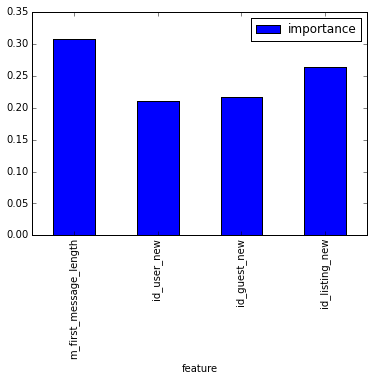

In [22]:
pd.DataFrame({'feature':list(test_features.columns[test_features.columns != 'ab']),'importance':importance}).plot(x = 'feature',kind = 'bar')

The importance of these four features are pretty even and (probably there is no bias). If we are about to doubt this:

There might be a little bias in the m_first_message_length, let's check the acceptance rate by m_first_message_length.

let's partition the data by m_first_message_length and :

1.check the group assignment

2.do t-test in each group

Side note: here I used sklearn.preprocesing.labelencoder to convert the categorical variable to numeric for the sake of computational cost. It would be more robust to use pd.get_dummies() becasue in this way, no order information will be introduced to the features.

In [23]:
ratios = []
for i in range(9):
    data = merged_2[(merged_2['m_first_message_length'] > (200*i)) & (merged_2['m_first_message_length'] <= (200*(i+1)))]  
    
    print "message length range: ",200*i,' to ',200*(i+1)
    print 'control-test ratio: ',data.groupby('ab').size()[0]/float(data.groupby('ab').size()[1])
    print " "
    ratios.append(data.groupby('ab').size()[0]/float(data.groupby('ab').size()[1]))

message length range:  0  to  200
control-test ratio:  0.772063120982
 
message length range:  200  to  400
control-test ratio:  1.00669412976
 
message length range:  400  to  600
control-test ratio:  0.978971962617
 
message length range:  600  to  800
control-test ratio:  1.01666666667
 
message length range:  800  to  1000
control-test ratio:  1.25742574257
 
message length range:  1000  to  1200
control-test ratio:  1.13157894737
 
message length range:  1200  to  1400
control-test ratio:  0.96
 
message length range:  1400  to  1600
control-test ratio:  1.71428571429
 
message length range:  1600  to  1800
control-test ratio:  1.11111111111
 


In the range of (1400, 1600), the experiment group is highly unbalanced.

In [24]:
pvalue = []
for i in range(9):
    data = merged_2[(merged_2['m_first_message_length'] > (200*i)) & (merged_2['m_first_message_length'] <= (200*(i+1)))]
    result = ttest_ind(data[data['ab']==1]['accepted'],data[data['ab']==0]['accepted'])
    print "message length range: ",200*i,' to ',200*(i+1)
    print result
    print " "
    pvalue.append(result[1])

message length range:  0  to  200
(4.3711526354820895, 1.2774930897577355e-05)
 
message length range:  200  to  400
(-0.93501732695006157, 0.349837333208875)
 
message length range:  400  to  600
(1.69577641784315, 0.090112197835971727)
 
message length range:  600  to  800
(-2.2904990367981428, 0.022336669534817142)
 
message length range:  800  to  1000
(0.83608741604720949, 0.40398883266794205)
 
message length range:  1000  to  1200
(-2.4209262544175587, 0.017774778707822934)
 
message length range:  1200  to  1400
(-0.079700751301825426, 0.93681365636911273)
 
message length range:  1400  to  1600
(0.047959302640698934, 0.96230761125697473)
 
message length range:  1600  to  1800
(0.62347093432908818, 0.54125072678430397)
 


plot them together

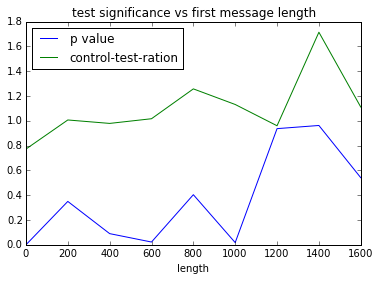

In [25]:
pd.DataFrame({'length':np.array(range(9))*200, 'p value': pvalue,'control-test-ration': ratios}).plot(x ='length', y = ['p value','control-test-ration'])
plt.title('test significance vs first message length')

The two plots above are consistent in the sense that there is a "peak" around length 1400 in both plots.

Also notice that, when the control-test is fairly balanced, the difference appears to be more "significant" than the time when control-test is not balanced.

It seems that message_length is playing an interesting role for hosts when they decide whether to accept the inquiry

In [26]:
merged_2.groupby('ab').agg({'m_first_message_length':np.mean})

,m_first_message_length
ab,
0,316.888157
1,324.447426


In [27]:
merged_2[merged_2['m_first_message_length']==0].groupby('ab').size()

ab
0    369
dtype: int64

All the users who did not wrote an inquiry message were in the control group, and there is a difference in the first_message_length for control and treatment groups

# Conclusion

1.what happens to the experience of contacting and booking a place on Airbnb when the guest is required to write a message like this?

From the two-sample t-test as a whole, we see no significant effect of this requirement on acceptance rate.
However, if we look at the A/B test in detail, we can find that "m_first_message_length" is also affecting the test result. 
First, it introduced bias to the experiment if we patition the whole by m_first_message_length;
Second, it is associated with the significance of the test.


2.We are also looking for suggestions for evaluating the future of this change?

As mentioned above, further experiment should be designed to exclude the potential effect of this variable.

3.Should we launch the experiment to everyone or stop it?

We should not becasue: 
a. the effect is not significant in the test; 
b.we have not figured out the interaction between it and other factors. If we launch it to everyone, we might get a different picture. 
c. it's not worth it given the insignificance of the change and extra inconvenience brought to users.

4.How would you explain the results and the decision to a non-technical person, who is smart but not a statistician?

I would not address the concept of "p-value", but only make some plots to show that there is no "huge" difference of acceptance before and after the treatment. I'll use words like:

"There is no obvious change before and after treatment".
"The acceptance rate for both groups are similar, with one being 0.336928, the other being 0.335670".
"In the A/B test we conducted, there is other factor that might affect the test result. It should be controlled, but we did not. "